# National Parks Biodiversity Exploration

In [5]:
from matplotlib import pyplot as plt
import pandas as pd

# Overview
During this project I'll be exploring two CSV files. The first is `species_info.csv` with data about different species in our National Parks.

In [6]:
species = pd.read_csv('species_info.csv')

First, I inspected the species_info file - at first glance, there is a data frame with categories for scientific names, common names, and conservation status. 

In [6]:
print(species.head())

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  


In [7]:
print(species.describe())

              category    scientific_name        common_names  \
count             5824               5824                5824   
unique               7               5541                5504   
top     Vascular Plant  Castor canadensis  Brachythecium Moss   
freq              4470                  3                   7   

       conservation_status  
count                  191  
unique                   4  
top     Species of Concern  
freq                   161  


In [8]:
print(species.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB
None


# Understanding the data
To learn more about the data, I gathered the amount of unique species, values of the 'category' column, and the values of the 'conservation_status' column. 

In [7]:
species_count = species.scientific_name.nunique()
print(species_count)

5541


In [14]:
species_type = species.category.unique()
print(species_type)

['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


In [16]:
conservation_statuses = species.conservation_status.unique()
print(conservation_statuses)

[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


The conservation_status column has a few different values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currnetly neither in danger of extinction throughout all or a significant portion of its range

Next, I'll explore how many species belong to each of these categories. 

In [17]:
conservation_counts = species.groupby('conservation_status').scientific_name.nunique().reset_index()
print(conservation_counts)

  conservation_status  scientific_name
0          Endangered               15
1         In Recovery                4
2  Species of Concern              151
3          Threatened               10


The results of this count didn't look right - those numbers should be higher given the fact that there are over 200 species in the table. Since the groupby function does not include 'None,' I'll use .fillna to fill those values in and get an accurate result. 

In [18]:
species.fillna('No Intervention', inplace = True)

Now I'll run the same function as before.

In [19]:
conservation_counts = species.groupby('conservation_status').scientific_name.nunique().reset_index()
print(conservation_counts)

  conservation_status  scientific_name
0          Endangered               15
1         In Recovery                4
2     No Intervention             5363
3  Species of Concern              151
4          Threatened               10


Now I can create a bar chart using matplotlib to provide a visualization of these numbers. To start this off, I'll sort the columns based on the number of species in each category. 

The following code will create a DataFrame 'protection_counts' sorted by scientific name. I can then display a bar chart showing the conservation status by species.

In [20]:
protection_counts = species.groupby('conservation_status')\
    .scientific_name.nunique().reset_index()\
    .sort_values(by='scientific_name')

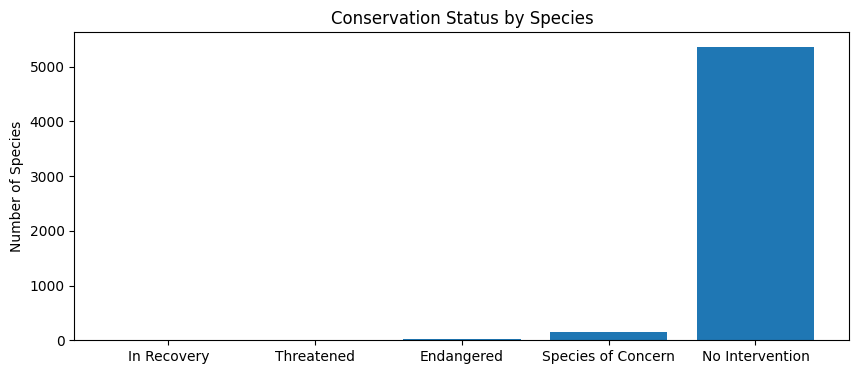

In [21]:
plt.figure(figsize=(10, 4))
ax = plt.subplot()
plt.bar(range(len(protection_counts)),protection_counts.scientific_name.values)
ax.set_xticks(range(len(protection_counts)))
ax.set_xticklabels(protection_counts.conservation_status.values)
plt.ylabel('Number of Species')
plt.title('Conservation Status by Species')
labels = [e.get_text() for e in ax.get_xticklabels()]
plt.show()

# Investigating the Endangered Species
Are certain types of species more likely to be endangered?

In [22]:
species['is_protected'] = species.conservation_status != 'No Intervention'

In [23]:
category_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index()

In [25]:
print(category_counts.head())

    category  is_protected  scientific_name
0  Amphibian         False               72
1  Amphibian          True                7
2       Bird         False              413
3       Bird          True               75
4       Fish         False              115


To make this data easier to read:

In [26]:
category_pivot = category_counts.pivot(columns='is_protected',
                      index='category',
                      values='scientific_name')\
                      .reset_index()

In [28]:
print(category_pivot)

is_protected           category  False  True
0                     Amphibian     72     7
1                          Bird    413    75
2                          Fish    115    11
3                        Mammal    146    30
4             Nonvascular Plant    328     5
5                       Reptile     73     5
6                Vascular Plant   4216    46


I'll change False to not_protected and True to protected to make the data more clear. I'll also create a column called percent_protected. 

In [29]:
category_pivot.columns = ['category', 'not_protected', 'protected']

In [31]:
category_pivot['percent_protected'] = category_pivot.protected / (category_pivot.protected + category_pivot.not_protected)

print(category_pivot)

            category  not_protected  protected  percent_protected
0          Amphibian             72          7           0.088608
1               Bird            413         75           0.153689
2               Fish            115         11           0.087302
3             Mammal            146         30           0.170455
4  Nonvascular Plant            328          5           0.015015
5            Reptile             73          5           0.064103
6     Vascular Plant           4216         46           0.010793


It looks as though species in Mammal are more likely to be endangered than species in Bird. Next I'll do a significance test to see if this is true. I'll be using a chi squared test, and the contingency table will look as follows: 

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Bird|?|?|

In [18]:
from scipy.stats import chi2_contingency

In [19]:
contingency = [[30, 146],
              [75, 413]]

pval = chi2_contingency(contingency)[1]
print(pval)

0.6875948096661336


This difference doesn't appear significant! Now I'll test the difference between Reptile and Mammal. 

In [20]:
contingency_reptile_mammal = [[30, 146],
                              [5, 73]]

pval_reptile_mammal = chi2_contingency(contingency_reptile_mammal)[1]
print(pval_reptile_mammal)

0.03835559022969898


This difference is indeed significant. Initially, we could see the slight difference in percentages of birds and mammals that fall into a protected category. The null hypothesis is that this difference was just chance. After comparing the percentages of protected reptiles and mammals and running the same chi-squared test, the p-value of ~0.038 showed this is significant. Therefore, we can conclude that certain types of species are more likely to be endangered than others.

# Sheep Spottings

The second csv file 'observations.csv' includes recorded sightings of different species at several national parks for the past 7 days. Here we can see the columns scientific_name, park_name, and observations.

In [22]:
observations = pd.read_csv('observations.csv')
print(observations.head())

            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85


Some scientists are studying the number of sheep sightings at different national parks. It would be helpful to know which rows of 'species' refer to sheep. 

The following lambda function allows a new column called 'is_sheep', which will be true if common_names contains 'sheep', and false otherwise. 

In [23]:
species['is_sheep'] = species.common_names.apply(lambda x: 'Sheep' in x)

Now I'll select the rows of species where is_sheep is True and examine the results.

In [27]:
species_is_sheep = species[species.is_sheep]
print(species_is_sheep)

            category              scientific_name  \
3             Mammal                   Ovis aries   
1139  Vascular Plant             Rumex acetosella   
2233  Vascular Plant           Festuca filiformis   
3014          Mammal              Ovis canadensis   
3758  Vascular Plant             Rumex acetosella   
3761  Vascular Plant            Rumex paucifolius   
4091  Vascular Plant                 Carex illota   
4383  Vascular Plant  Potentilla ovina var. ovina   
4446          Mammal      Ovis canadensis sierrae   

                                           common_names conservation_status  \
3     Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN   
1139                        Sheep Sorrel, Sheep Sorrell                 NaN   
2233                              Fineleaf Sheep Fescue                 NaN   
3014                       Bighorn Sheep, Bighorn Sheep  Species of Concern   
3758  Common Sheep Sorrel, Field Sorrel, Red Sorrel,...                 Na

A lot of these results are plants, so I'll add a check to make sure the category is 'Mammal'. 

In [28]:
sheep_species = species[(species.is_sheep) & (species.category == 'Mammal')]

Now I'll merge sheep_species with observations to get a DataFrame containing observations of sheep. 

In [29]:
sheep_observations = pd.merge(
  sheep_species,
  observations
)

print(sheep_observations.head)

<bound method NDFrame.head of    category          scientific_name  \
0    Mammal               Ovis aries   
1    Mammal               Ovis aries   
2    Mammal               Ovis aries   
3    Mammal               Ovis aries   
4    Mammal          Ovis canadensis   
5    Mammal          Ovis canadensis   
6    Mammal          Ovis canadensis   
7    Mammal          Ovis canadensis   
8    Mammal  Ovis canadensis sierrae   
9    Mammal  Ovis canadensis sierrae   
10   Mammal  Ovis canadensis sierrae   
11   Mammal  Ovis canadensis sierrae   

                                         common_names conservation_status  \
0   Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN   
1   Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN   
2   Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN   
3   Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN   
4                        Bighorn Sheep, Bighorn Sheep  Species o

Now I can easily find out how the total number of sheep observations across the three species that were made at each national park. For this I can use 'groupby' to get the sum of observations for each park name, saved to the variable obs_by_park. 

In [30]:
obs_by_park = sheep_observations.groupby('park_name').observations.sum().reset_index()
print(obs_by_park)

                             park_name  observations
0                  Bryce National Park           250
1  Great Smoky Mountains National Park           149
2            Yellowstone National Park           507
3               Yosemite National Park           282


The following bar chart shows the different number of observations per week at each park.

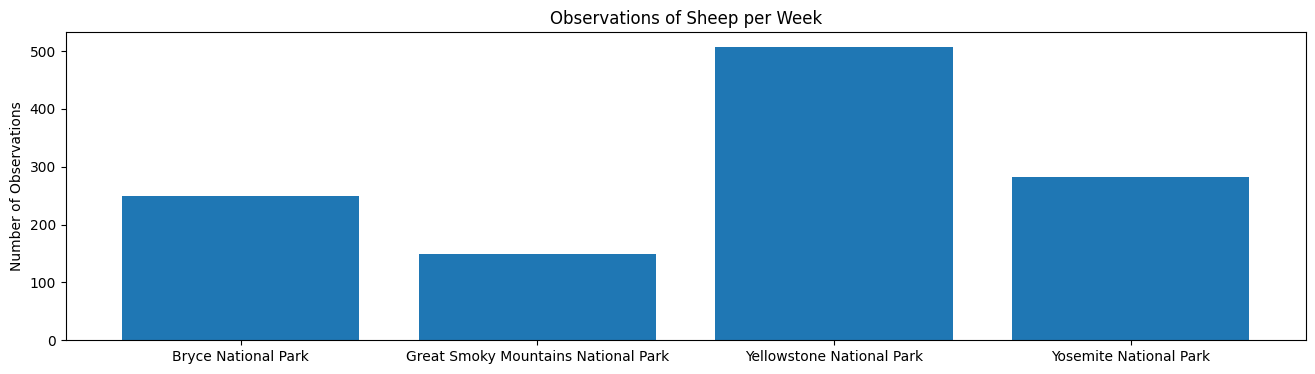

In [31]:
plt.figure(figsize=(16, 4))
ax = plt.subplot()
plt.bar(range(len(obs_by_park)),
        obs_by_park.observations.values)
ax.set_xticks(range(len(obs_by_park)))
ax.set_xticklabels(obs_by_park.park_name.values)
plt.ylabel('Number of Observations')
plt.title('Observations of Sheep per Week')
plt.show()

# Foot and Mouth Reduction Effort

The scientists know that 15% of sheep at Bryce National Park have foot and mouth disease.  Park rangers at Yellowstone National Park have been running a program to reduce the rate of foot and mouth disease at that park.  The scientists want to test whether or not this program is working.  They want to be able to detect reductions of at least 5 percentage points.  For instance, if 10% of sheep in Yellowstone have foot and mouth disease, they'd like to be able to know this, with confidence. I also want to know how many weeks it would take to observe enough sheep at Bryce and Yellowstone.

In [9]:
baseline = 15

minimum_detectable_effect = 100*5./15

sample_size_per_variant = 870

yellowstone_weeks_observing = sample_size_per_variant/507.

bryce_weeks_observing = sample_size_per_variant/250.

print(bryce_weeks_observing)
print(yellowstone_weeks_observing)

3.48
1.7159763313609468


Given a baseline of 15% occurrence of foot and mouth disease in sheep at Bryce National Park, if the scientists wanted to be sure that a >5% drop in observed cases of foot and mouth disease in the sheep at Yellowstone was significant they would have to observe at least 870 sheep.

This would take approximately one week of observing in Yellowstone to see that many sheep, or approximately two weeks in Bryce to see that many sheep.

# Conclusion

Initially there appeared to be a difference in the perecentages of birds and mammals that are in the protected category, which could have been the result of chance. The chi-squared test gave a p-value of ~.0688, meaning the difference between the percentages was not significant. However, the percentages of protected reptiles and mammals gave a p-value of ~0.038 using the. same test, which is significant. Therefore, certain types of species are more likely to be endangered than others.

It was also found that given a baseline of 15% occurrence of foot and mouth disease in sheep at Bryce National Park, if scientists wanted to be sure that a >5% drop in observed cases was significant they must observe at least 870 sheep. This would take about one week of observation in Yellowstone, and about two weeks in Bryce to see enough sheep. 